In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.random_graph_dataset as random_graph_dataset
import feature.graph_conversions as graph_conversions
import model.discrete_diffusers as discrete_diffusers
import model.gnn as gnn
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
# Create the data loader for training
num_nodes, node_dim = 10, 5

dataset = random_graph_dataset.RandomGraphDataset(
    num_nodes, node_dim, num_items=6400,
    graph_type="tree", noise_level=0
)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=False, num_workers=0  # TODO: allow multi-processing
)

### Create the model

In [4]:
# Create the diffuser and model
diffuser = discrete_diffusers.BernoulliZeroDiffuser(100, 10, (1,))

t_limit = 1000

model = gnn.GraphLinkPredictor(node_dim, t_limit, num_gnn_layers=4).to(DEVICE)

### Sanity checks and unit tests

In [5]:
# Check the canonical ordering of edges from torch-geometric Data
data = next(iter(data_loader))

# Get the set of edges in this batch of graphs that actually exist
edge_indices = set(["%d-%d" % (a, b) for a, b in data.edge_index.t().cpu().numpy()])

# Get the binary vector of edge indicators in canonical ordering
edges = graph_conversions.pyg_data_to_edge_vector(data).cpu().numpy()

# Get the list of all possible edges in the same canonical ordering
all_edge_indices = graph_conversions.edge_vector_to_pyg_data(data, 1, reflect=False).t().cpu().numpy()

assert np.sum(edges) == len(edge_indices) / 2
for i, (a, b) in enumerate(all_edge_indices):
    # For each possible edge, check its corresponding entry in `edges` and verify
    # its presence (or absence) in the set of edges that actually exist
    e1, e2 = "%d-%d" % (a, b), "%d-%d" % (b, a)
    if edges[i] == 0:
        assert e1 not in edge_indices and e2 not in edge_indices
    else:
        assert e1 in edge_indices and e2 in edge_indices

/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


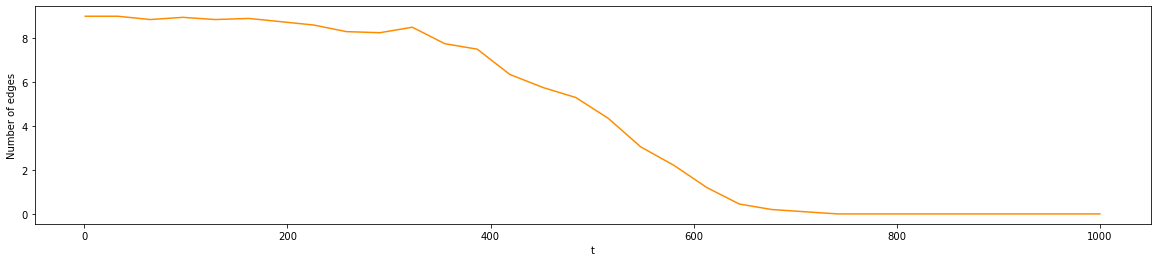

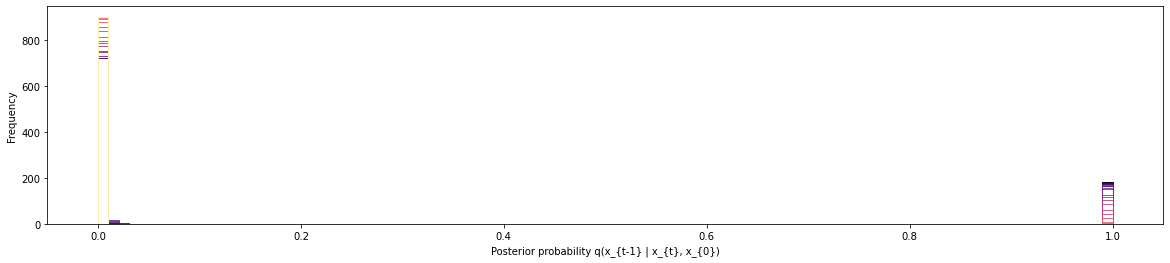

In [6]:
# Check that we can specify different times in a batch to noise edges, and
# the posterior probabilities are also as expected
num_batches_to_test = 20

# Take a set of uniformly distributed times from 0 to t_limit, one for each
# graph in a batch
graph_times = np.linspace(1, t_limit, data_loader.batch_size).astype(int)

noised_graphs = {t : [] for t in graph_times}
post_probs = {t : [] for t in graph_times}
for _ in range(num_batches_to_test):
    data = next(iter(data_loader))
    e0, edge_batch_inds = graph_conversions.pyg_data_to_edge_vector(data, return_batch_inds=True)

    # Create time vector over the graphs in a single batch, but in random
    # order
    graph_times_batch = np.random.permutation(graph_times)
    t_e = torch.tensor(graph_times_batch, device=DEVICE)[edge_batch_inds]

    # Noise graphs and compute posterior probabilities
    et, p = diffuser.forward(e0[:, None], t_e)  # Do the noising on E x 1 tensors
    et, p = et[:, 0], p[:, 0]
    data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)
    graphs = graph_conversions.split_pyg_data_to_nx_graphs(data)
    
    # Save the graphs and posterior probabilities by time
    for i in range(data_loader.batch_size):
        noised_graphs[graph_times_batch[i]].append(graphs[i])
        post_probs[graph_times_batch[i]].append(p[edge_batch_inds == i].cpu().numpy())

# Check the noising process in terms of number of edges (in sorted order of time)
edge_counts = [np.mean([g.number_of_edges() for g in noised_graphs[t]]) for t in graph_times]
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(graph_times, edge_counts, color="darkorange")
ax.set_xlabel("t")
ax.set_ylabel("Number of edges")
plt.show()

# Check the posterior probabilities over time (in sorted order of time)
fig, ax = plt.subplots(figsize=(20, 4))
cmap = plt.get_cmap("magma")
bins = np.linspace(0, 1, 100)
for t_i, t in enumerate(graph_times):
    p = np.concatenate(post_probs[t])
    ax.hist(p, bins=bins, histtype="step", color=cmap(t_i / len(graph_times)), alpha=0.8)
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
plt.show()

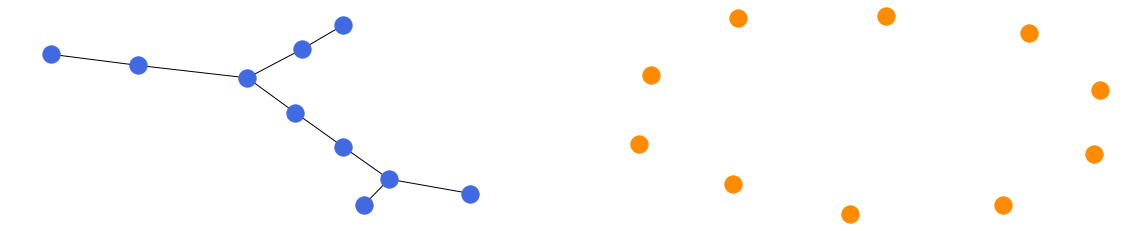

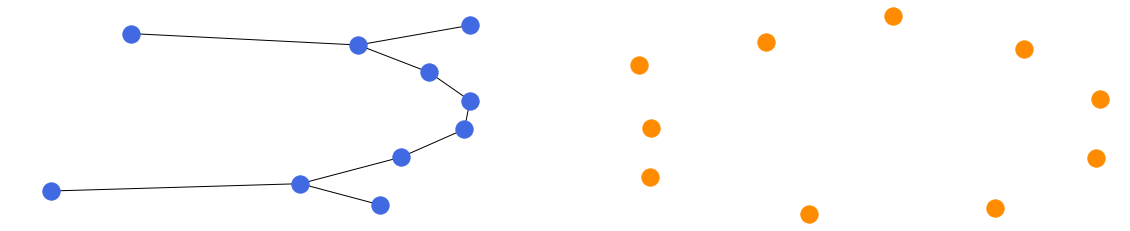

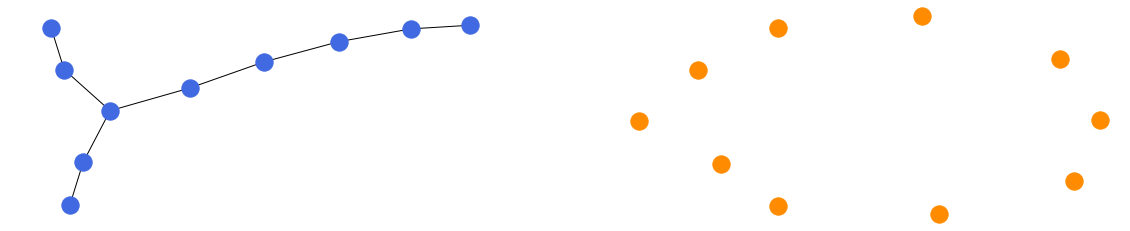

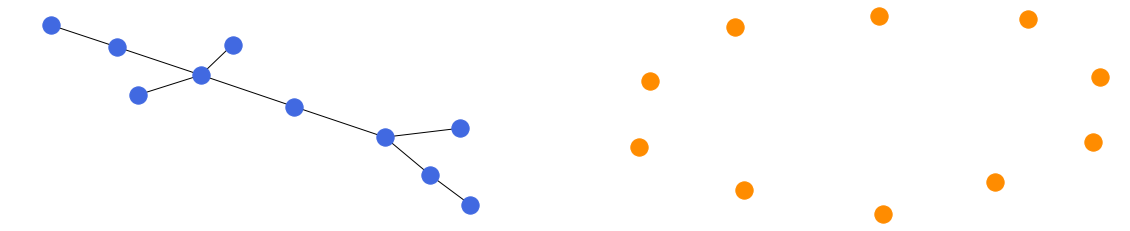

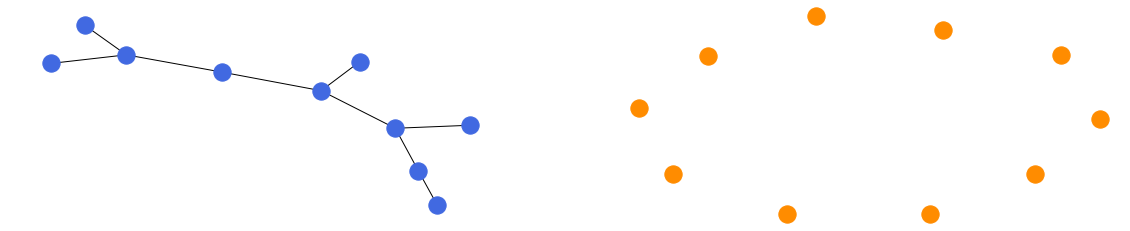

In [7]:
# Check the NetworkX graphs in a batch directly from the data loader, and
# after adding noise for a long time
data = next(iter(data_loader))

graphs_0 = graph_conversions.split_pyg_data_to_nx_graphs(data)

e0, edge_batch_inds = graph_conversions.pyg_data_to_edge_vector(data, return_batch_inds=True)
t_e = torch.tile(torch.tensor([t_limit], device=DEVICE), (e0.shape[0],))
et = diffuser.forward(e0[:, None], t_e, return_posterior=False)[:, 0]  # Do the noising on E x 1 tensors
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)

graphs_t = graph_conversions.split_pyg_data_to_nx_graphs(data)

for i in np.random.choice(len(graphs_0), replace=False, size=min(5, len(graphs))):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    nx.draw(graphs_0[i], ax=ax[0], node_color="royalblue")
    nx.draw(graphs_t[i], ax=ax[1], node_color="darkorange")
    plt.show()

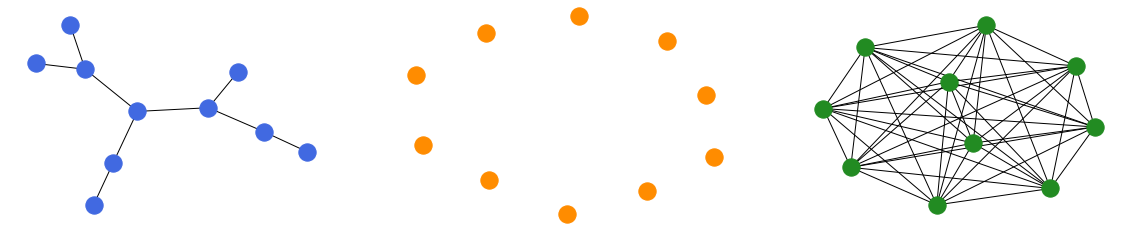

In [8]:
# Check that we can modify just a single graph's edges from a batch and
# only that graph changes
data = next(iter(data_loader))

graphs_0 = graph_conversions.split_pyg_data_to_nx_graphs(data)
edges, edge_batch_inds = graph_conversions.pyg_data_to_edge_vector(data, return_batch_inds=True)
edge_batch_inds = edge_batch_inds.cpu().numpy()

# Remove all edges from one graph
test_i = np.random.choice(edge_batch_inds)
mask = edge_batch_inds == test_i
edges[mask] = 0
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, edges)
graphs_1 = graph_conversions.split_pyg_data_to_nx_graphs(data)

# Add all edges to one graph
edges[mask] = 1
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, edges)
graphs_2 = graph_conversions.split_pyg_data_to_nx_graphs(data)

fig, ax = plt.subplots(ncols=3, figsize=(20, 4))
nx.draw(graphs_0[test_i], ax=ax[0], node_color="royalblue")
nx.draw(graphs_1[test_i], ax=ax[1], node_color="darkorange")
nx.draw(graphs_2[test_i], ax=ax[2], node_color="forestgreen")
plt.show()

for i in range(len(data.ptr) - 1):
    if test_i != i:
        assert nx.algorithms.isomorphism.is_isomorphic(graphs_0[i], graphs_1[i])
        assert nx.algorithms.isomorphism.is_isomorphic(graphs_0[i], graphs_2[i])
    else:
        assert not nx.algorithms.isomorphism.is_isomorphic(graphs_0[i], graphs_1[i])
        assert not nx.algorithms.isomorphism.is_isomorphic(graphs_0[i], graphs_2[i])

In [9]:
# Check that if we modify one graph in a batch (e.g. by changing edges or node features),
# only that graph's edge probabilities changes (as predicted from the model)
data = next(iter(data_loader))
model.eval()  # Disable normalization layers at test time

e0, edge_batch_inds = graph_conversions.pyg_data_to_edge_vector(data, return_batch_inds=True)

# Fix some random time vector for the nodes
graph_times = torch.randint(t_limit, size=(data_loader.batch_size,), device=DEVICE) + 1
t_v = graph_times[data.batch].float()

# Run a forward pass through the model
preds_orig = model(data, t_v).detach().cpu().numpy()

# Pick a graph index to modify
test_i = np.random.choice(data_loader.batch_size)
edge_mask = edge_batch_inds == test_i
node_mask = data.batch == test_i

# Modify the edges for one graph and run another forward pass
e1 = torch.clone(e0)
e1[edge_mask] = 1 - e1[edge_mask]
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, e1)
preds_edge_mod = model(data, t_v).detach().cpu().numpy()
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, e0)  # Revert back
preds_edge_revert = model(data, t_v).detach().cpu().numpy()

# Modify the node features for the same graph and run another forward pass
node_feats0 = data.x
node_feats1 = torch.clone(node_feats0)
node_feats1[node_mask] = node_feats1[node_mask] + torch.randn_like(node_feats1[node_mask])
data.x = node_feats1
preds_node_mod = model(data, t_v).detach().cpu().numpy()
data.x = node_feats0  # Revert back
preds_node_revert = model(data, t_v).detach().cpu().numpy()

# Modify the time for the same graph and run another forward pass
t_v1 = torch.clone(t_v)
t_v1[node_mask] = t_v1[node_mask] + 1  # Might run over t_limit but it doesn't matter for the test
preds_t_mod = model(data, t_v1).detach().cpu().numpy()

edge_mask = edge_mask.cpu().numpy()  # For convenience

# Verify only that one graph's edge probabilities have changed from the model
assert np.allclose(preds_orig, preds_edge_revert)
assert np.allclose(preds_orig, preds_node_revert)
assert not np.allclose(preds_orig[edge_mask], preds_edge_mod[edge_mask])
assert not np.allclose(preds_orig[edge_mask], preds_node_mod[edge_mask])
assert not np.allclose(preds_orig[edge_mask], preds_t_mod[edge_mask])
assert np.allclose(preds_orig[~edge_mask], preds_edge_mod[~edge_mask])
assert np.allclose(preds_orig[~edge_mask], preds_node_mod[~edge_mask])
assert np.allclose(preds_orig[~edge_mask], preds_t_mod[~edge_mask])

Expected cycles in limit: 13.52
Expected edges in limit: 22.50


  0%|          | 0/999 [00:00<?, ?it/s]

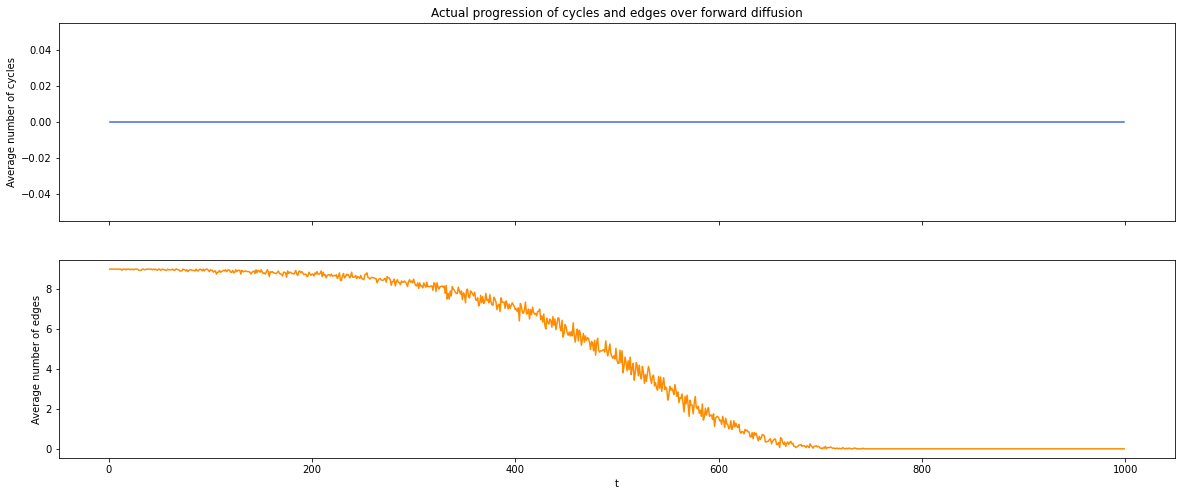

In [10]:
# Check progression of the number of cycles and edges
er_num_cycles, er_num_edges = [], []
for _ in range(500):
    er_graph = nx.erdos_renyi_graph(int(np.mean(num_nodes)), 0.5)
    er_num_cycles.append(len(nx.cycle_basis(er_graph)))
    er_num_edges.append(nx.number_of_edges(er_graph))

print("Expected cycles in limit: %.2f" % np.mean(er_num_cycles))
print("Expected edges in limit: %.2f" % np.mean(er_num_edges))

t_vals = np.arange(1, t_limit)
num_cycles = np.empty((len(t_vals), data_loader.batch_size))
num_edges = np.empty((len(t_vals), data_loader.batch_size))
data = next(iter(data_loader))
e0 = graph_conversions.pyg_data_to_edge_vector(data)
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et = diffuser.forward(e0[None], t_tens, return_posterior=False)[0]  # Do the noising on 1 x E tensors
    data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)  # Note: this modifies `data`
    
    # Convert to a list of NetworkX graphs
    graphs = graph_conversions.split_pyg_data_to_nx_graphs(data)
    for j, g in enumerate(graphs):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(t_vals, np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(t_vals, np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("t")

ax[0].set_title("Actual progression of cycles and edges over forward diffusion")
plt.show()

  0%|          | 0/999 [00:00<?, ?it/s]

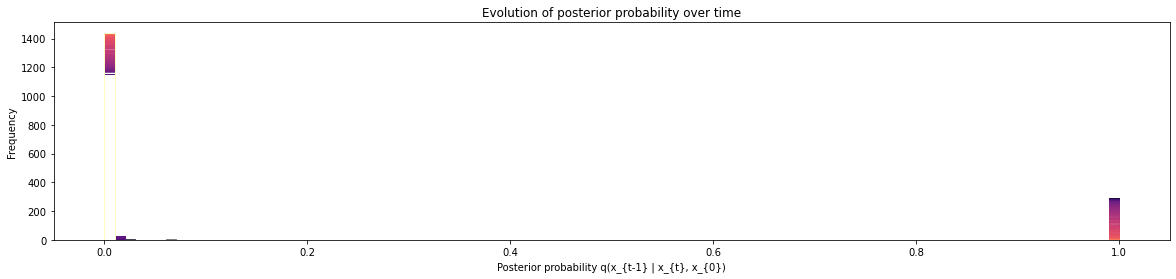

In [11]:
# Check progression of posterior probability
t_vals = np.arange(1, t_limit)
data = next(iter(data_loader))
e0 = graph_conversions.pyg_data_to_edge_vector(data)
posterior_probs = np.empty((len(t_vals), e0.shape[0]))
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et, p = diffuser.forward(e0[None], t_tens)  # Do the noising on 1 x E tensors
    et, p = et[0], p[0]
    posterior_probs[i] = p.cpu().numpy()
    
fig, ax = plt.subplots(figsize=(20, 4))
times = np.tile(t_vals[:, None], (1, posterior_probs.shape[1]))
cmap = plt.get_cmap("magma")
bins = np.linspace(0, 1, 100)
for t_i in range(len(t_vals)):
    ax.hist(posterior_probs[t_i], bins=bins, histtype="step", color=cmap(t_i / len(t_vals)), alpha=0.5)
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
ax.set_title("Evolution of posterior probability over time")
plt.show()

In [12]:
# Check virtual node addition
data_1 = next(iter(data_loader))
data_2 = data_1.clone()
graph_conversions.add_virtual_nodes(data_2)

num_graphs = len(data_1.ptr) - 1

# Correct shapes
num_nodes = data_1.x.shape[0]
assert data_1.edge_index.shape[1] + (2 * num_nodes) == data_2.edge_index.shape[1]
assert data_2.x.shape[0] == num_graphs + num_nodes
assert data_2.batch.shape[0] == num_graphs + num_nodes
assert data_2.edge_type.shape[0] == data_1.edge_index.shape[1] + (2 * num_nodes)

# First part of data unchanged
assert torch.all(data_1.edge_index == data_2.edge_index[:, :data_1.edge_index.shape[1]])
assert torch.all(data_1.x == data_2.x[:data_1.x.shape[0]])
assert torch.all(data_1.batch == data_2.batch[:data_1.batch.shape[0]])
assert torch.all(data_1.ptr == data_2.ptr)

# First part of edge type is all 0
assert torch.all(data_2.edge_type[:data_1.edge_index.shape[1]] == 0)

for i in range(num_graphs):
    node_start_i, node_end_i = data_1.ptr[i], data_1.ptr[i + 1]
    virtual_node_i = num_nodes + i
    
    # New edges added are all present and edge type is correct
    for j in range(node_start_i, node_end_i):
        mask_1 = (data_2.edge_index[0] == virtual_node_i) & (data_2.edge_index[1] == j)
        mask_2 = (data_2.edge_index[1] == virtual_node_i) & (data_2.edge_index[0] == j)
        assert torch.sum(mask_1) == 1
        assert torch.sum(mask_2) == 1
        assert data_2.edge_type[mask_1] == 1
        assert data_2.edge_type[mask_2] == 2
        
    # Edge types are correct
    
    # New virtual node has all 0 for features
    assert torch.all(data_2.x[virtual_node_i] == 0)
    
    # Batch of new virtual node is large index
    assert data_2.batch[virtual_node_i] == num_graphs + i
    
# Check edge vectors are the same even after adding virtual nodes
edges_1, edge_batch_inds_1 = graph_conversions.pyg_data_to_edge_vector(data_1, return_batch_inds=True)
edges_2, edge_batch_inds_2 = graph_conversions.pyg_data_to_edge_vector(data_2, return_batch_inds=True)
assert torch.all(edges_1 == edges_2)
assert torch.all(edge_batch_inds_1 == edge_batch_inds_2)
edge_index_1 = graph_conversions.edge_vector_to_pyg_data(data_1, edges_1, reflect=True)
edge_index_2 = graph_conversions.edge_vector_to_pyg_data(data_2, edges_2, reflect=True)
assert torch.all(edge_index_1 == edge_index_2)